In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from tqdm import tqdm
from abc import ABC, abstractmethod, abstractclassmethod
import matplotlib.pyplot as plt

In [206]:
class AbstractController(ABC):
    def __init__(self) -> None:
        super().__init__()

    @abstractmethod
    def step(self, params, e, err_hist):
        pass

    def reset_error(self):
        return jnp.array([])

    @abstractmethod
    def init_params(self):
        pass

    def update_params(self, params, lr, gradient):
        return params - lr*gradient

In [423]:
class NeuralController(AbstractController):
    a_func_map = {
        'relu': lambda x: jnp.maximum(x, 0),
        'sigmoid': lambda x: 1 / (1 + jnp.exp(-x)),
        'tanh': lambda x: jnp.tanh(x),
        'leaky_relu': lambda x: jnp.maximum(x, 0.01*x),
        'softmax': lambda x: jnp.exp(x - jnp.max(x)) / jnp.exp(x - jnp.max(x)).sum(axis=0), # assumes multi-variable input
        'linear': lambda x: x,
    }

    def __init__(self, inputs, outputs, hidden_layers, a_funcs) -> None:
        super().__init__()
        self.activation_functions = a_funcs
        self.layers = np.concatenate(([inputs], hidden_layers, [outputs])).astype(int)

    def step(self, params, e, err_hist, activation_functions) -> jax.Array:
        de = (e - err_hist[-1])
        ie = jnp.sum(jnp.array(err_hist))
        x = jnp.array([e,de,ie])

        for (w, b), a_func in zip(params, activation_functions):
            a = self.a_func_map[a_func.lower()]
            x = jnp.dot(x, w) + b
            x = a(x.flatten())
        return x.flatten()

    def init_params(self):
        sender = self.layers[0]
        params = []
        for receiver in self.layers[1:]:
            weights = np.random.uniform(-1, 1, (sender, receiver))
            biases = np.random.uniform(-1, 1, (1, receiver))
            sender = receiver
            params.append([weights, biases])
        return params

    def update_params(self, params, lr, gradient):
        for i, (w_grad, b_grad) in enumerate(gradient):
            params[i][0] -= lr*w_grad
            params[i][1] -= lr*b_grad
        return params

In [397]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum(axis=0)
controller.a_func_map['softmax'](np.array([-1.0, 0.5, 1.0]))


Array([0.07769558, 0.3482074 , 0.574097  ], dtype=float32)

In [424]:
controller = NeuralController(3,2,[5],['relu','softmax'])
params = controller.init_params()
# controller.step(params, .1, jnp.array([.1]))
e = 5.0
eh = jnp.array([5.3])
gradf = jax.jacrev(controller.step, argnums=[0])
gradf(params, e, eh, controller.activation_functions)

([[Array([[[ 5.52639249e-05,  1.23301743e-05,  0.00000000e+00,
            -2.90711941e-05,  7.32979533e-05],
           [-3.31583760e-06, -7.39810901e-07, -0.00000000e+00,
             1.74427271e-06, -4.39788028e-06],
           [ 5.85797643e-05,  1.30699855e-05,  0.00000000e+00,
            -3.08154667e-05,  7.76958332e-05]],
   
          [[-5.53163045e-05, -1.22877427e-05, -0.00000000e+00,
             2.90771713e-05, -7.34011992e-05],
           [ 3.31898036e-06,  7.37265054e-07,  0.00000000e+00,
            -1.74463139e-06,  4.40407484e-06],
           [-5.86352835e-05, -1.30250082e-05, -0.00000000e+00,
             3.08218005e-05, -7.78052781e-05]]], dtype=float32),
   Array([[[ 1.1052785e-05,  2.4660349e-06,  0.0000000e+00, -5.8142386e-06,
             1.4659591e-05]],
   
          [[-1.1063261e-05, -2.4575486e-06, -0.0000000e+00,  5.8154342e-06,
            -1.4680240e-05]]], dtype=float32)],
  [Array([[[ 3.5573055e-05, -3.5659203e-05],
           [ 1.9720786e-05, -1.9768542

In [405]:
controller.step(params, 5., np.array([5.3]), controller.activation_functions)

Array([0.98136353, 0.01863651], dtype=float32)

In [425]:
x = np.array([5.,-.3, 5.3])
for (w, b) in params:
    x = np.dot(x, w)
    x = x + b
    x = controller.a_func_map['softmax'](x[0])
x

Array([0.74411666, 0.25588334], dtype=float32)

In [248]:
params

[[array([[ 0.49978961, -0.04691856, -0.23654275],
         [ 0.16786442,  0.68593097, -0.37783385],
         [ 0.8752941 ,  0.77420435, -0.27676884]]),
  array([[-0.07673257, -0.80195053, -0.90016038]])],
 [array([[ 0.51142652,  0.54541267,  0.32868851],
         [ 0.70431015, -0.83093803, -0.41149019],
         [-0.14195684, -0.56301722,  0.88602232]]),
  array([[ 0.52183084, -0.59443791, -0.05034039]])],
 [array([[-0.08252038],
         [ 0.67673539],
         [ 0.09866737]]),
  array([[-0.67952468]])]]

In [127]:
np.dot(np.array([5., -0.3, 10.3]), params[0][0]).flatten()

array([-7.6954402])

In [191]:
def f(x):
    return 0.5*x[0] + 1*x[1] + -1*x[2]
jax.grad(f)(params[0][0].flatten())

Array([ 0.5,  1. , -1. ], dtype=float32)

In [32]:
controller.step()

TypeError: NeuralController.step() missing 3 required positional arguments: 'e', 'err_hist', and 'activation_functions'

In [95]:
def relu(x):
    return (x + np.sqrt(np.power(x, 2))) / 2

array([1., 0.])

In [648]:
params[0]

[array([[ 6.93936637,  8.31535238],
        [-3.55931663, -2.98522298],
        [ 0.16114123,  3.21835643]]),
 array([[1.99536861, 1.32365364]])]

In [634]:
arr = [1, 1, 1]
for i in arr:
    i -= 1
arr

[1, 1, 1]

In [19]:
def fun(x):
    return x
g = jax.jacrev(fun)
g(1.0)

Array(1., dtype=float32, weak_type=True)

In [75]:
def controller(x):
    return jnp.array([x**2, 1/(0.1 + x**2), x*jnp.sin(x)*10])

def plant(x):
    return x[0]*0.1 + x[1]*1 + x[2]*1.1

def step(x):
    U = controller(x)
    S = plant(U)
    return S

jax.value_and_grad(step)(4.7245)


(Array(-49.689003, dtype=float32),
 Array(-9.443693, dtype=float32, weak_type=True))

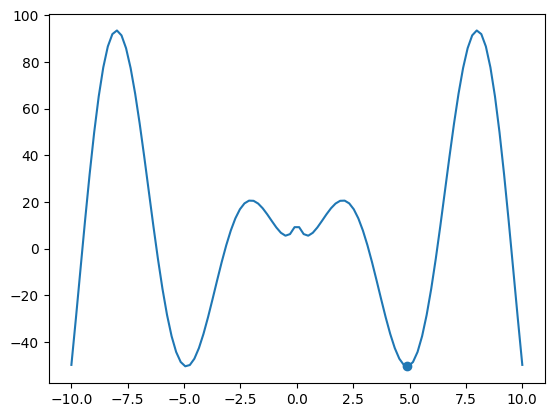

In [77]:
x = 5.0
gr = jax.grad(step)
g = gr(x)
for i in range(1000):
    x -= 0.01*g
    g = gr(x)
    if np.abs(g) < 0.01:
        break
xp = np.linspace(-10, 10, 100)
yp = step(xp)
plt.plot(xp,yp)
plt.scatter(x, step(x))
plt.show()

In [588]:
controller.step(params, 1, jnp.array([1]))

Array(7.98943, dtype=float32)

In [603]:
g = gradf(params, e, eh)
params = controller.update_params(params, 0.1, g)
e -= 0.5
eh = jnp.append(eh, e)
g, eh

([[Array([[-0., -0.],
          [-0., -0.],
          [-0., -0.]], dtype=float32),
   Array([[-0., -0.]], dtype=float32)],
  [Array([[0., 0.],
          [0., 0.]], dtype=float32),
   Array([[7.577401, 5.595716]], dtype=float32)],
  [Array([[1.7093694],
          [5.2147217]], dtype=float32),
   Array([[1.]], dtype=float32)]],
 Array([10. ,  9.5,  9. ,  8.5,  8. ,  7.5,  7. ,  6.5,  6. ,  5.5,  5. ,
         4.5,  4. ,  3.5,  3. ,  2.5], dtype=float32))

In [7]:
def mse(y, y_hat):
    return jnp.mean((y - y_hat)**2)

y = jnp.array([1,1,2,0])
y_hat = jnp.array([1,1,2,2])
mse(y, y_hat)

Array(1., dtype=float32)

In [22]:
def f(p):
    return p[0]*p[1] + p[1]

gradfunc = jax.value_and_grad(f)

params = [5.0, 5.0]
for i in range(10):
    v, g = gradfunc(params)
    g = np.array(g)
    params -= 0.01 * g

In [134]:

class Controller:
    def step(self, params, e, hist):
        de = e - hist[-1]
        ie = jnp.sum(hist) + e

        hist = jnp.append(hist, e)

        kp, kd, ki = params
        return (kp*e + kd*de + ki*ie).item()
        
    def reset(self):
        return jnp.array([0])
    
    def reset_params(self):
        return jnp.array([0,0,0])

    def update_params(self, params, gradient):
        return params - 0.01*gradient

controller = Controller()

In [ ]:
params = controller.reset_params()

gradfunc = jax.value_and_grad(controller.step)
for i in range(2):
    hist = controller.reset()
    e = 1/i

    controller.step(,)
    gradient = gradfunc(params, e, hist )
    params = controller.update_params(params, gradient)





In [1]:
controller

TypeError: can't multiply sequence by non-int of type 'float'

4

In [138]:
g = jax.grad(controller.step)

gradient = g(params, e, hist)
params = controller.update_params(params, gradient)

In [ ]:
g()

In [133]:
controller.step(1), controller.hist

(17, Array([0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32))